In [1]:
import asyncio
from collections import defaultdict
import openai
from tqdm.asyncio import tqdm

# Create async client
async_client = openai.AsyncOpenAI(
    base_url="http://localhost:8000/v1",
    api_key="EMPTY",
)

In [2]:
from pathlib import Path

prompts = [
    # Repetitive tokens (single word) -> extremely predictable.
    (
        "Repeat the word 'hello' exactly 120 times separated by a single "
        "space, then on a new line write: COUNT=120."
    ),
    # Simple counting sequence.
    (
        "List the numbers 1 through 60 separated by commas only (no space). "
        "Finish with a newline saying LENGTH=60."
    ),
    # Alphabet repetition.
    (
        "Output the lowercase English alphabet repeated 4 times without "
        "separators (total length 26*4). Then state: DONE."
    ),
    # JSON numeric array.
    "Produce a JSON array of the integers from 1 to 50 inclusive.",
    # Line-numbered repetition.
    (
        "Create 30 lines. Each line i (starting at 1) must be: i: "
        "speculative decoding accelerates generation."
    ),
    # Even numbers.
    "List the first 70 even numbers separated by a single space.",
    # Fixed token block (A's) with grouping.
    (
        "Write 200 capital letter A characters. Insert a newline after every "
        "50 characters."
    ),
    # Poem with identical line pattern (predictable line starts).
    (
        "Generate a 20-line poem where every line starts with 'Speed gains:' "
        "followed by the line number."
    ),
    # Simple table.
    (
        "Create a 10-row markdown table with two columns: n and n_squared "
        "for n=1..10."
    ),
    # Repetition with periodic marker.
    (
        "Print the word 'data' 160 times; after every 40 occurrences add the "
        "token |MARK|."
    ),
    # Fibonacci small range (deterministic sequence).
    "List the first 25 Fibonacci numbers separated by spaces.",
    # Binary sequence.
    "Output a line of 128 characters alternating 0 and 1 starting with 0.",
    # Squares.
    "Give the squares of 1..40 as 'i^2=val' each on its own line.",
    # Multiplication table.
    (
        "Provide a 12x12 multiplication table; rows each start with row "
        "number then a colon then 12 products separated by spaces."
    ),
    # Simple predictable narrative.
    (
        "Write 15 sentences each exactly 'Speculative decoding reduces "
        "latency.' numbered (1) .. (15)."
    ),
    # JSON mapping.
    (
        "Return a JSON object mapping letters a through j to their 1-based "
        "positions."
    ),
]
long_prompt = Path("/home/shanes/projects/vllm_v1_specdec/docs/design/paged_attention.md").read_text()
long_prompt = f"Summarize your learnings from this passage: {long_prompt}"
prompts.append(long_prompt)
prompt_map = {i: prompt for i, prompt in enumerate(prompts)}

In [3]:

sem_limit = 12
sem = asyncio.Semaphore(sem_limit)
async def get_acceptance_length(k, prompt, temperature: float = 0.0):
    async with sem:
        response = await async_client.chat.completions.create(
            model="meta-llama/Llama-3.1-8B-Instruct",
            messages=[
                {"role": "user", "content": prompt}
            ],
            temperature=temperature,
            max_tokens=1024,
            top_p=1.0,
            timeout=60.0,
        )
        return k, response.model_extra.get("acceptance_lengths", None)

async def run_experiment(temperature: float, repeats: int = 16):
    # Run all requests concurrently
    tasks = [get_acceptance_length(k, prompt, temperature=temperature) for k, prompt in prompt_map.items() for _ in range(repeats)]
    results = await tqdm.gather(*tasks, desc=f"Processing prompts @ T={temperature}")

    # Collect results
    pal = defaultdict(list)
    for k, accepted_length in results:
        pal[k].append(accepted_length)
    return pal


In [4]:
# Plot best-fit lines for each prompt's mean acceptance lengths over time
# Wrapped in a function that saves the plot to a file and displays it.
import numpy as np
import matplotlib.pyplot as plt

def plot_best_fit(mean_als, prompt_map=None, filename="mean_al_bestfit.png"):
    if not mean_als:
        raise ValueError("mean_als is empty; nothing to plot.")

    plt.figure(figsize=(12, 7))
    colors = plt.cm.get_cmap('tab20', len(mean_als))

    lines_plotted = 0
    for i, (idx, ys) in enumerate(sorted(mean_als.items(), key=lambda kv: kv[0])):
        # Filter out None/NaN values just in case
        clean_y = [v for v in ys if v is not None and not (isinstance(v, float) and np.isnan(v))]
        if len(clean_y) < 2:
            # Need at least 2 points for a linear fit
            continue

        x = np.arange(len(clean_y), dtype=float)
        # Linear fit y = m*x + b
        m, b = np.polyfit(x, clean_y, 1)

        # Draw a dense line across the range for smoothness
        x_dense = np.linspace(x.min(), x.max(), 200)
        y_dense = m * x_dense + b

        label_parts = [f"#{idx}", f"slope={m:.3f}"]
        # Optionally include a short prompt hint if available
        if prompt_map is not None and idx in prompt_map:
            prompt_hint = str(prompt_map[idx])
            # Truncate to keep legend readable
            prompt_hint = prompt_hint.replace('\n', ' ')
            if len(prompt_hint) > 40:
                prompt_hint = prompt_hint[:37] + '...'
            label_parts.append(prompt_hint)

        plt.plot(x_dense, y_dense, color=colors(i), linewidth=2.0, label=' | '.join(label_parts))

        # Optional: scatter the original mean points for context
        plt.scatter(x, clean_y, color=colors(i), s=18, alpha=0.45)
        lines_plotted += 1

    plt.title('Best-fit trends of mean acceptance lengths over time (per prompt)')
    plt.xlabel('Repeat index (time)')
    plt.ylabel('Mean acceptance length')
    if lines_plotted:
        plt.legend(loc='upper left', bbox_to_anchor=(1.02, 1), borderaxespad=0.0)
    plt.grid(True, linestyle='--', alpha=0.3)
    plt.tight_layout()
    # Save then show
    plt.savefig(filename, dpi=150, bbox_inches='tight')
    plt.show()

# Example (optional):
# plot_best_fit(mean_als, prompt_map=prompt_map, filename="mean_al_bestfit_current.png")

In [5]:
# stored here for now
# mean_als_temp0 = mean_als

Processing prompts @ T=0.0:   0%|          | 0/272 [00:00<?, ?it/s]

Processing prompts @ T=0.0: 100%|██████████| 272/272 [03:05<00:00,  1.46it/s]
/tmp/ipykernel_2024700/2059966880.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab20', len(mean_als))

/tmp/ipykernel_2024700/2059966880.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab20', len(mean_als))


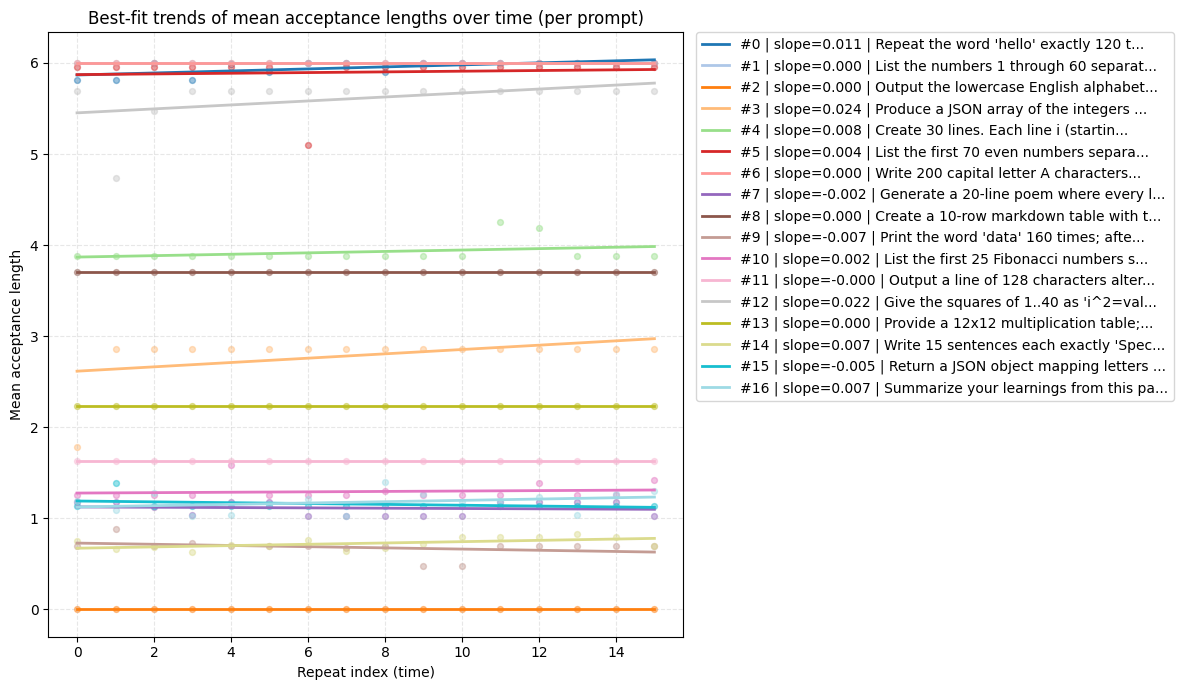

In [6]:
# Run experiments at multiple temperatures and save plots
from pathlib import Path

# Temperatures to test
temperatures = [0.0]
repeats = 16

# Ensure output directory exists
out_dir = Path(f"plots/{temperatures=}@{repeats}_long")
out_dir.mkdir(parents=True, exist_ok=True)

results_by_T = {}
means_by_T = {}

for T in temperatures:
    pal = await run_experiment(temperature=T, repeats=repeats)
    results_by_T[T] = pal
    # Compute mean_als for this temperature
    mean_als_T = defaultdict(list)
    for idx, pals in pal.items():
        for al in pals:
            if al is None:
                continue
            try:
                mean_als_T[idx].append(np.mean(al))
            except Exception:
                # Skip malformed records
                continue
    means_by_T[T] = mean_als_T

    # Save and display plot
    fname = out_dir / f"mean_al_bestfit_T{T}.png"
    plot_best_fit(mean_als_T, prompt_map=prompt_map, filename=str(fname))



In [7]:
means_by_T



{
    0.0: defaultdict(<class 'list'>, {
        0: [
            5.80794701986755,
            5.80794701986755,
            6.0,
            5.80794701986755,
            5.993197278911564,
            5.899328859060403,
            6.0,
            6.0,
            5.906040268456376,
            6.0,
            6.0,
            6.0,
            6.0,
            6.0,
            6.0,
            6.0
        ],
        1: [6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0],
        2: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
        3: [
            1.7818181818181817,
            2.8607594936708862,
            2.8607594936708862,
            2.8607594936708862,
            2.8607594936708862,
            2.8607594936708862,
            2.8607594936708862,
            2.8607594936708862,
            2.8607594936708862,
            2.8607594936708862,
            2.8607594936708862,
            2.8607594936708862,

/tmp/ipykernel_2024700/1118250004.py:31: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab20', len(prompt_indices))


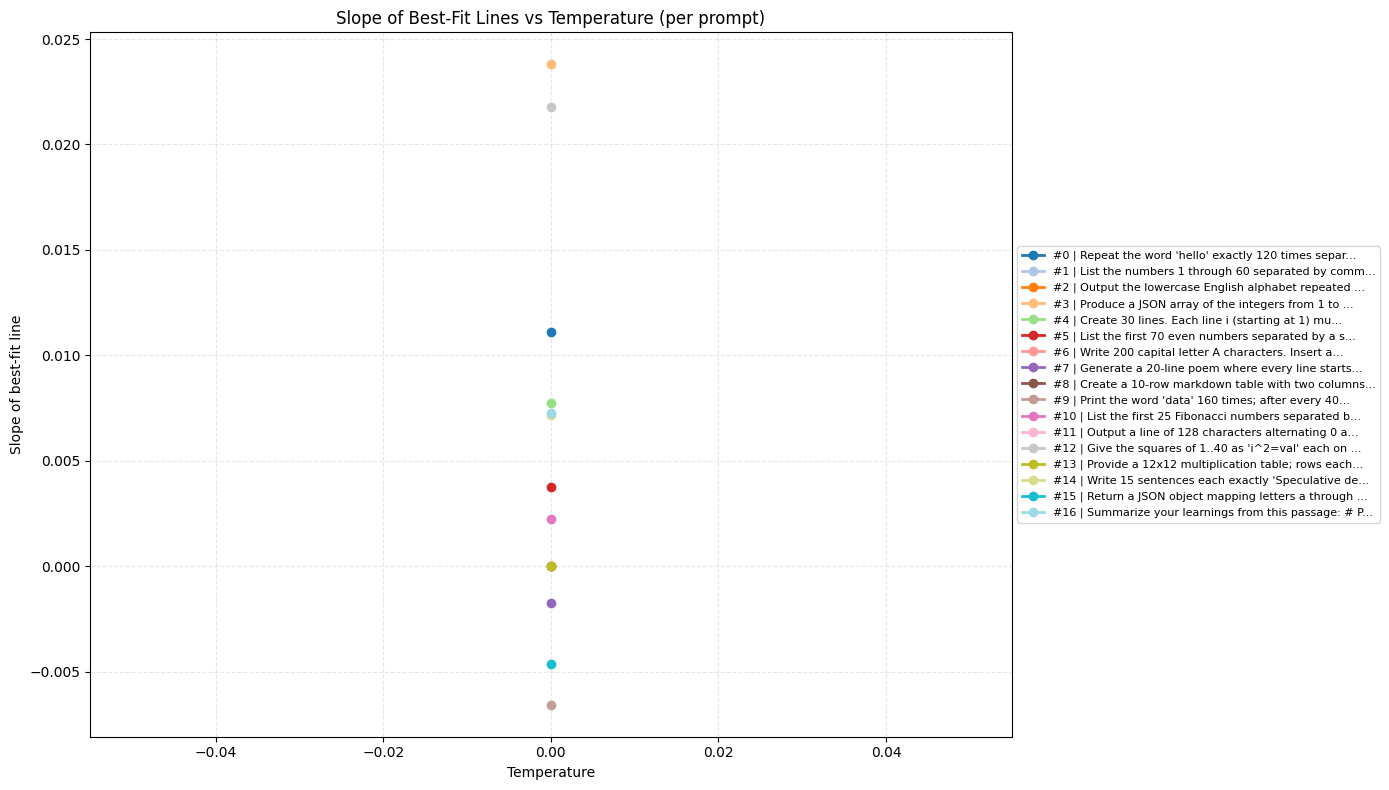

Slope plot saved to: plots/temperatures=[0.0]@16_long/slopes_vs_temperature.png


In [8]:
# Plot slopes of best-fit lines for each prompt across temperatures
import matplotlib.pyplot as plt
import numpy as np

def compute_slopes(mean_als_dict):
    """Compute slopes for each prompt index in mean_als_dict."""
    slopes = {}
    for idx, ys in mean_als_dict.items():
        clean_y = [v for v in ys if v is not None and not (isinstance(v, float) and np.isnan(v))]
        if len(clean_y) < 2:
            slopes[idx] = np.nan  # Can't compute slope with < 2 points
            continue
        x = np.arange(len(clean_y), dtype=float)
        m, b = np.polyfit(x, clean_y, 1)
        slopes[idx] = m
    return slopes

# Compute slopes for each temperature
slopes_by_T = {}
for T, mean_als_T in means_by_T.items():
    slopes_by_T[T] = compute_slopes(mean_als_T)

# Prepare data for plotting
prompt_indices = sorted(set().union(*[slopes.keys() for slopes in slopes_by_T.values()]))
temperatures_sorted = sorted(slopes_by_T.keys())

# Create the plot
plt.figure(figsize=(14, 8))

# Plot each prompt as a line across temperatures
colors = plt.cm.get_cmap('tab20', len(prompt_indices))
for i, prompt_idx in enumerate(prompt_indices):
    slopes_for_prompt = []
    temps_for_prompt = []
    
    for T in temperatures_sorted:
        if prompt_idx in slopes_by_T[T] and not np.isnan(slopes_by_T[T][prompt_idx]):
            slopes_for_prompt.append(slopes_by_T[T][prompt_idx])
            temps_for_prompt.append(T)
    
    if len(slopes_for_prompt) > 0:
        # Create label with prompt hint
        label_parts = [f"#{prompt_idx}"]
        if prompt_idx in prompt_map:
            prompt_hint = str(prompt_map[prompt_idx])
            prompt_hint = prompt_hint.replace('\n', ' ')
            if len(prompt_hint) > 50:
                prompt_hint = prompt_hint[:47] + '...'
            label_parts.append(prompt_hint)
        
        plt.plot(temps_for_prompt, slopes_for_prompt, 
                marker='o', linewidth=2, markersize=6,
                color=colors(i), label=' | '.join(label_parts))

plt.title('Slope of Best-Fit Lines vs Temperature (per prompt)')
plt.xlabel('Temperature')
plt.ylabel('Slope of best-fit line')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=8)
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()

# Save and show
slope_plot_path = out_dir / "slopes_vs_temperature.png"
plt.savefig(slope_plot_path, dpi=150, bbox_inches='tight')
plt.show()

print(f"Slope plot saved to: {slope_plot_path}")